In [77]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

##### All code is available at: https://github.com/avilarenan/AnaliseEspectralDeSeriesTemporais

%matplotlib inline
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from scipy import signal
import random
import pywt
import pywt.data
import pandas as pd

YLIM_DEFAULT_OFFSET = 10

def clear_plots():
    plt.clf()
    plt.close()
    
def simple_plot(data, title):
    clear_plots()
    fig = plt.figure(figsize=(20, 4))
    plt.plot(data)
    fig.suptitle(title, fontsize=20)
    plt.show()
    
def rebuild_signal(ca, cd, w, title):
    rebuilt_signal = pywt.idwt(ca, cd, w, 'smooth') # inverse dwt transform for recomposing the signal 
    simple_plot(rebuilt_signal, title)

def plot_coeffs(data, w, title, level, use_dwt=True):
    clear_plots()
    """Show dwt or swt coefficients for given data and wavelet."""
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []

    if use_dwt:
        for i in range(5):
            (a, d) = pywt.dwt(a, w, mode)
            if len(a) > 1:
                ca.append(a)
                cd.append(d)
    else:
        coeffs = pywt.swt(data, w, level)  # [(cAn, cDn), ..., (cA1, cD1)]
        for a, d in reversed(coeffs):
            ca.append(a)
            cd.append(d)

    fig = plt.figure(figsize=(20, 12))
    ax_main = fig.add_subplot(len(ca) + 1, 1, 1)
    ax_main.set_title(title, fontsize=14)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, x in enumerate(ca):
        ax = fig.add_subplot(len(ca) + 1, 2, 3 + i * 2)
        ax.plot(x, 'r')
        if i == 0:
            ax.set_title("Approximation coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        if use_dwt:
            ax.set_xlim(0, len(x) - 1)
        else:
            ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

    for i, x in enumerate(cd):
        ax = fig.add_subplot(len(cd) + 1, 2, 4 + i * 2)
        ax.plot(x, 'g')
        if i == 0:
            ax.set_title("Detail coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        # Scale axes
        ax.set_xlim(0, len(x) - 1)
        if use_dwt:
            ax.set_ylim(min(0, 1.4 * min(x)), max(0, 1.4 * max(x)))
        else:
            vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
            ax.set_ylim(min(0, 2 * min(vals) if len(vals) > 0 else -YLIM_DEFAULT_OFFSET), max(0, 2 * max(vals)) if len(vals) > 0 else YLIM_DEFAULT_OFFSET)
    plt.show()
    
    return ca, cd
    
def plot_family_of_wavelets(plot_data=[('db', (4, 3)), ('sym', (4, 3)), ('coif', (3, 2))], second_plot_data=[]):
    clear_plots()
    for family, (rows, cols) in plot_data:
        fig = plt.figure(figsize=(20, 12))
        fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)
        colors = itertools.cycle('bgrcmyk')

        wnames = pywt.wavelist(family)
        i = iter(wnames)
        for col in range(cols):
            for row in range(rows):
                try:
                    wavelet = pywt.Wavelet(next(i))
                except StopIteration:
                    break
                phi, psi, x = wavelet.wavefun(level=5)

                color = next(colors)
                ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
                ax.set_title(wavelet.name + " phi")
                ax.plot(x, phi, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
                ax.set_title(wavelet.name + " psi")
                ax.plot(x, psi, color)
                ax.set_xlim(min(x), max(x))

    for family, (rows, cols) in second_plot_data:
        fig = plt.figure(figsize=(20, 12))
        fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)

        colors = itertools.cycle('bgrcmyk')
        wnames = pywt.wavelist(family)
        i = iter(wnames)
        for col in range(cols):
            for row in range(rows):
                try:
                    wavelet = pywt.Wavelet(next(i))
                except StopIteration:
                    break
                phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
                row *= 2

                color = next(colors)
                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
                ax.set_title(wavelet.name + " phi")
                ax.plot(x, phi, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
                ax.set_title(wavelet.name + " psi")
                ax.plot(x, psi, color)
                ax.set_xlim(min(x), max(x))

                row += 1
                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
                ax.set_title(wavelet.name + " phi_r")
                ax.plot(x, phi_r, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
                ax.set_title(wavelet.name + " psi_r")
                ax.plot(x, psi_r, color)
                ax.set_xlim(min(x), max(x))

    plt.show()
    
def plot_signal_decomp(data, w, title):
    clear_plots()
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(20, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Approximation Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Detail Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        
    plt.show()

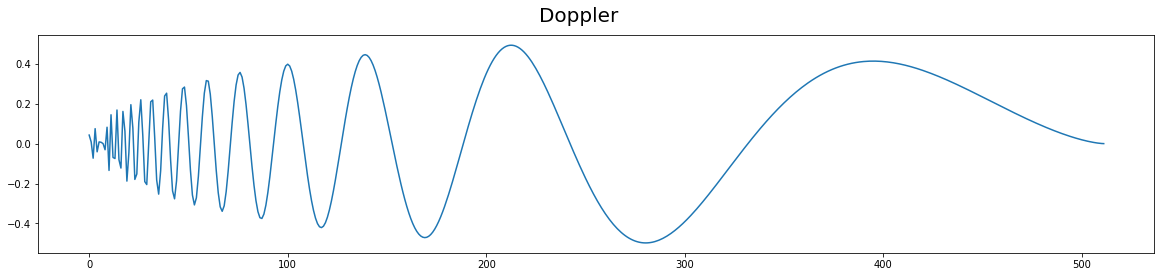

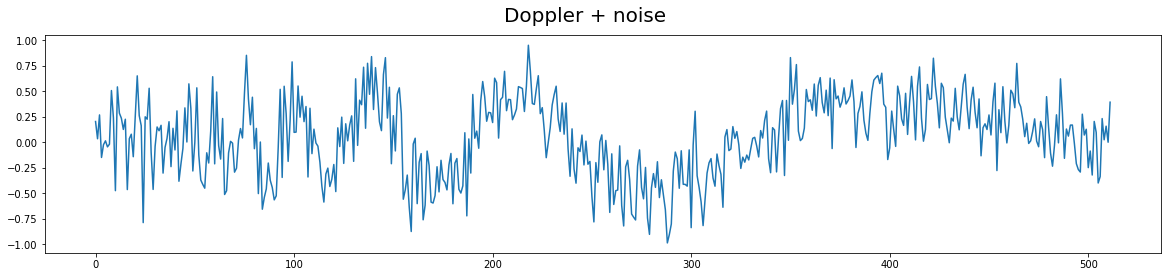

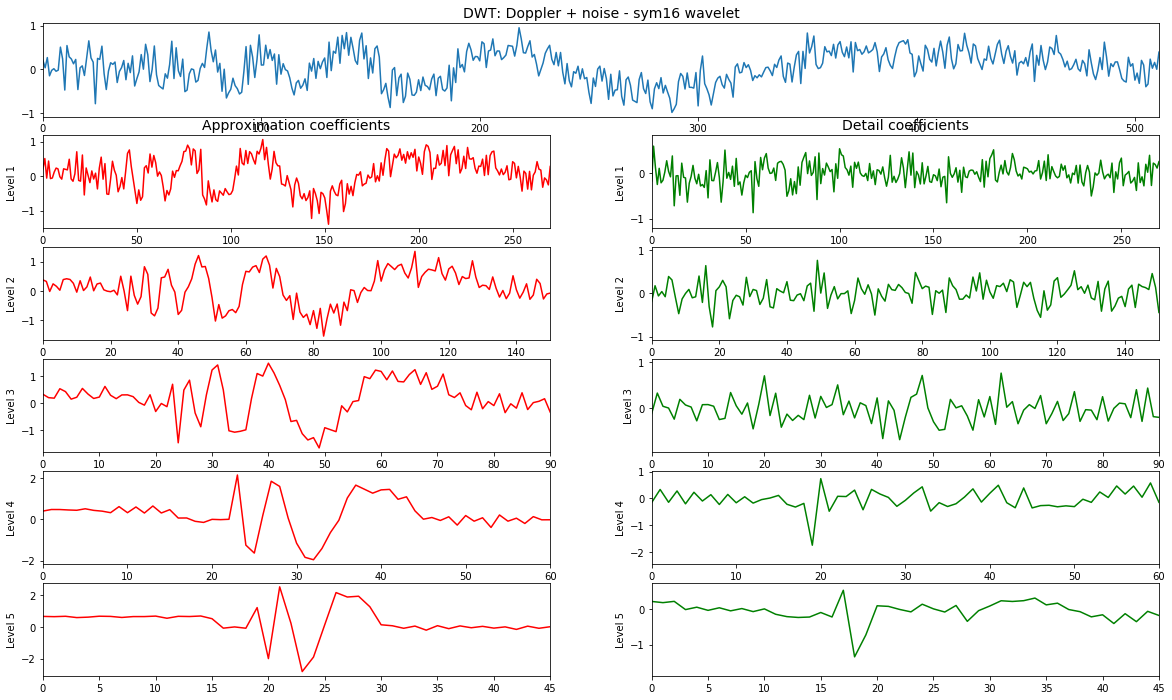

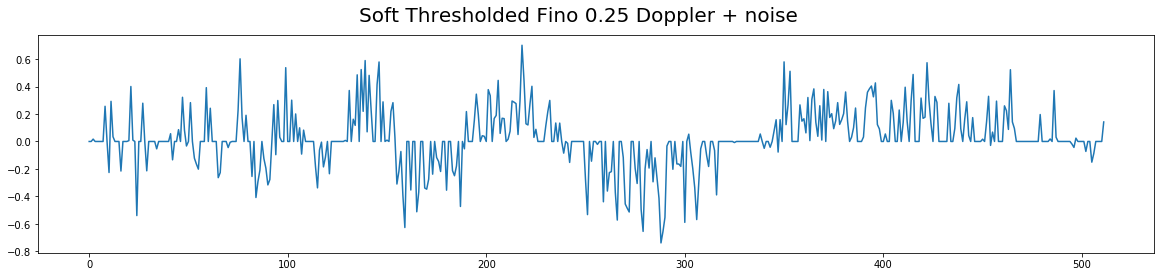

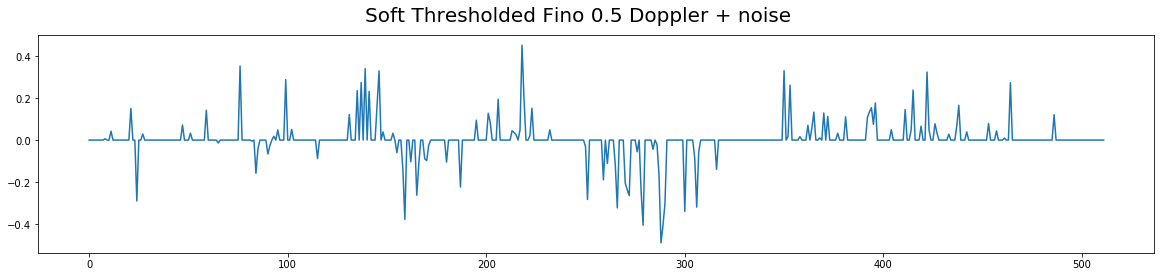

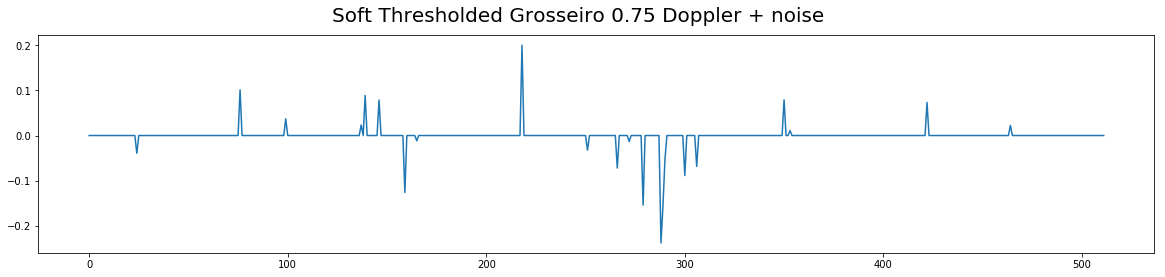

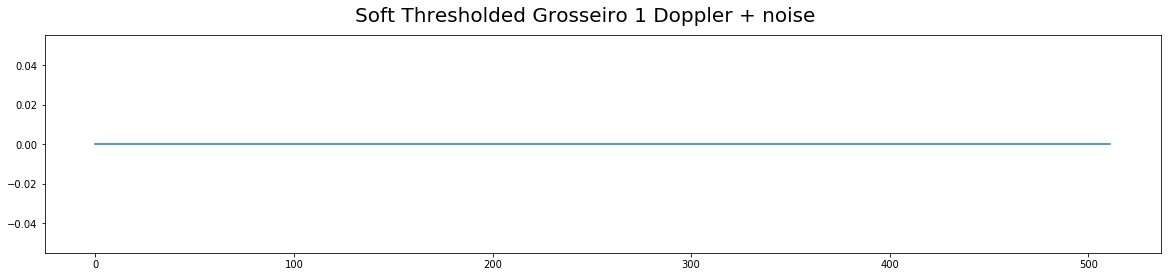

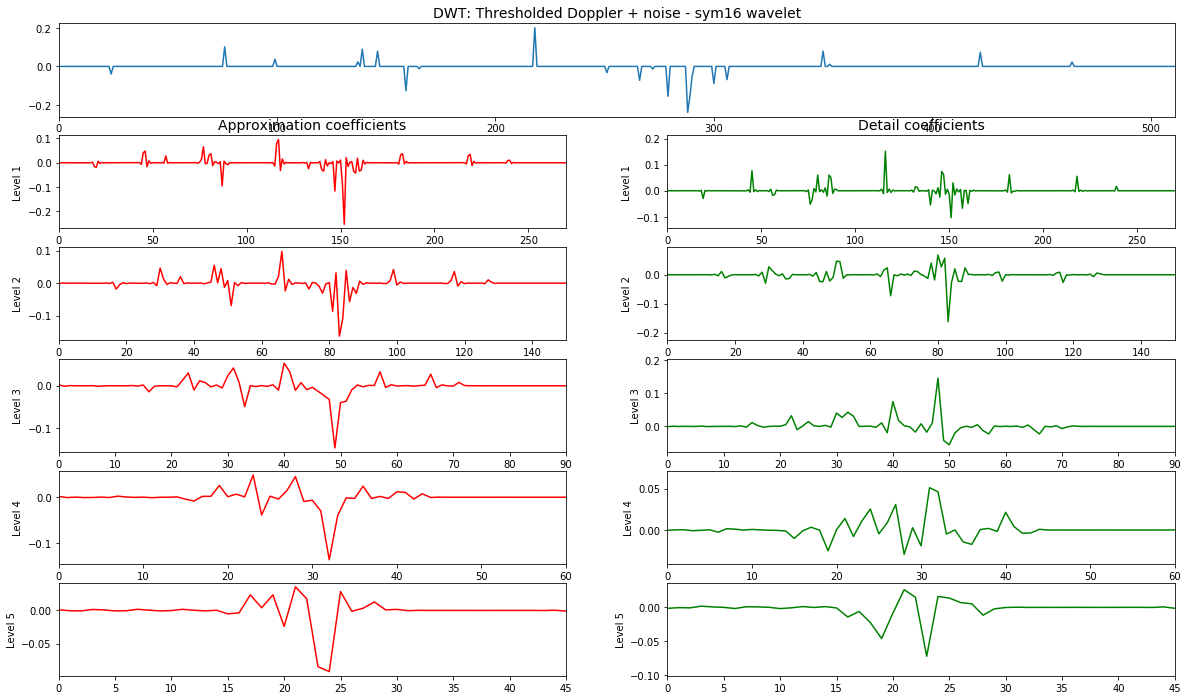

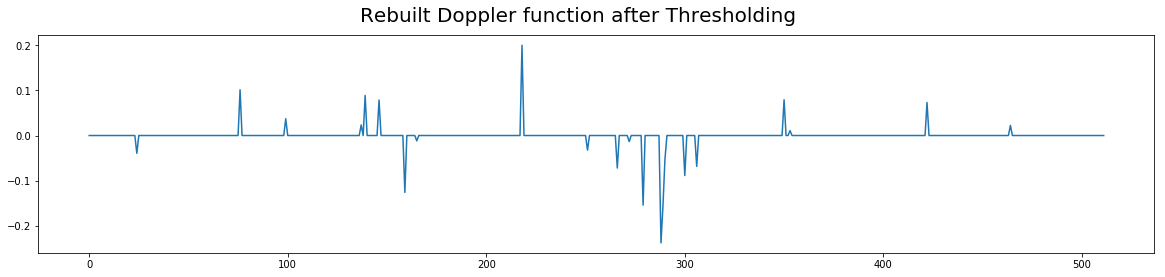

In [54]:
''' 
Exercício 1 
Lista 5
Professora: Chang
Aluno: Renan de Luca Avila
'''

time_series_length = 512
noise = np.random.normal(0,0.25,time_series_length) # média = 0, variância = 0.25 => ruído branco

''' 
a)
'''
doppler = pywt.data.demo_signal(name='Doppler', n=time_series_length)
simple_plot(doppler, 'Doppler')

doppler_plus_noise = doppler + noise
simple_plot(doppler_plus_noise, 'Doppler + noise')

''' 
b)
'''
wavelet_name = 'sym16'
mode = pywt.Modes.sp1DWT = 1
# Show DWT coefficients
use_dwt = True
plot_coeffs(doppler_plus_noise, wavelet_name,
            f"DWT: Doppler + noise - {wavelet_name} wavelet",
            2,
            use_dwt)

''' 
c)
'''
lambda_fino = 0.25 # alpha*log(T)
thresholded_doppler_plus_noise_fino = pywt.threshold(doppler_plus_noise, lambda_fino, 'soft')
simple_plot(thresholded_doppler_plus_noise_fino, f'Soft Thresholded Fino {lambda_fino} Doppler + noise')

lambda_fino = 0.5 # alpha*log(T)
thresholded_doppler_plus_noise_fino = pywt.threshold(doppler_plus_noise, lambda_fino, 'soft')
simple_plot(thresholded_doppler_plus_noise_fino, f'Soft Thresholded Fino {lambda_fino} Doppler + noise')

lambda_groseeiro = 0.75 # pi*sqrt(log(T)/3)
thresholded_doppler_plus_noise_grosseiro = pywt.threshold(doppler_plus_noise, lambda_groseeiro, 'soft')
simple_plot(thresholded_doppler_plus_noise_grosseiro, f'Soft Thresholded Grosseiro {lambda_groseeiro} Doppler + noise')

chosen_thresholded = thresholded_doppler_plus_noise_grosseiro

lambda_groseeiro = 1 # pi*sqrt(log(T)/3)
thresholded_doppler_plus_noise_grosseiro = pywt.threshold(doppler_plus_noise, lambda_groseeiro, 'soft')
simple_plot(thresholded_doppler_plus_noise_grosseiro, f'Soft Thresholded Grosseiro {lambda_groseeiro} Doppler + noise')

''' 
d)
'''
# Escolhi o lambda = 0.75 pela representatividade dos picos dos dados
ca, cd = plot_coeffs(chosen_thresholded, wavelet_name,
            f"DWT: Thresholded Doppler + noise - {wavelet_name} wavelet",
            2,
            use_dwt)
ca = ca[0].tolist()
cd = cd[0].tolist()

''' 
e)
'''

rebuild_signal(ca, cd, wavelet_name, 'Rebuilt Doppler function after Thresholding')

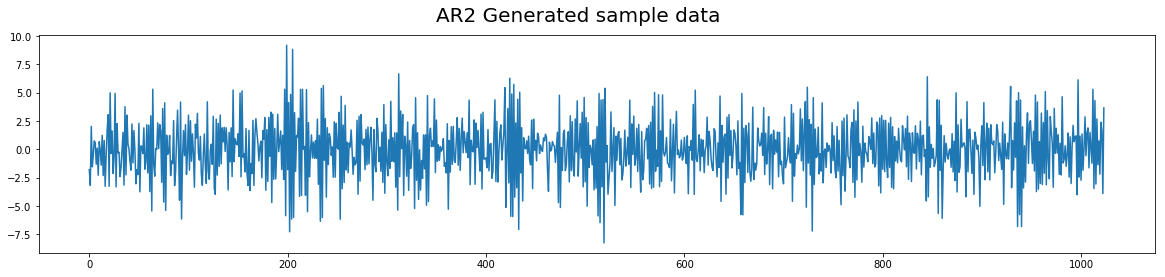

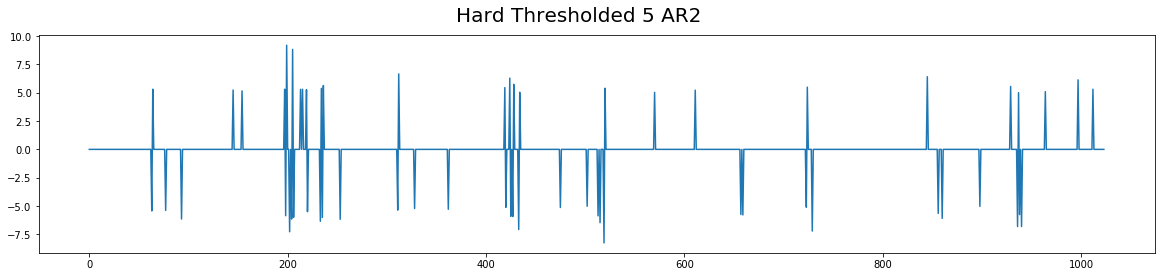

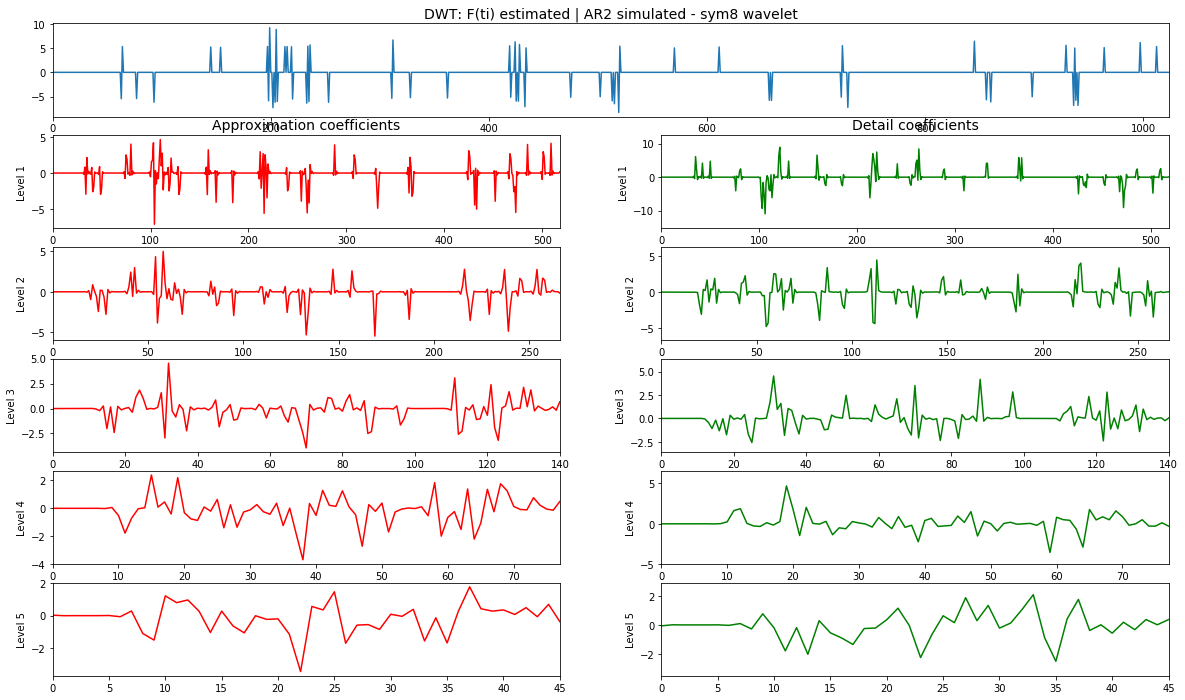

In [73]:
''' 
Exercício 2 
Lista 5
Professora: Chang
Aluno: Renan de Luca Avila
'''
# AR2 Simulated
ar2 = np.array([0.5, 0.3])
AR_object = ArmaProcess(ar2, np.array([1]))
simulated_data = AR_object.generate_sample(nsample=1024)
simple_plot(simulated_data, 'AR2 Generated sample data')

# Limiarização/Thresholding
lambda_ = 5 # universal thresholding
simulated_data_thresholded = pywt.threshold(simulated_data, lambda_, 'hard')
simple_plot(simulated_data_thresholded, f'Hard Thresholded {lambda_} AR2')

# Estimation through wavelets
wavelet_name = 'sym8'
mode = pywt.Modes.sp1DWT = 1
# Show DWT coefficients
use_dwt = True
ca,cd = plot_coeffs(simulated_data_thresholded, wavelet_name,
            f"DWT: F(ti) estimated | AR2 simulated - {wavelet_name} wavelet",
            2,
            use_dwt)


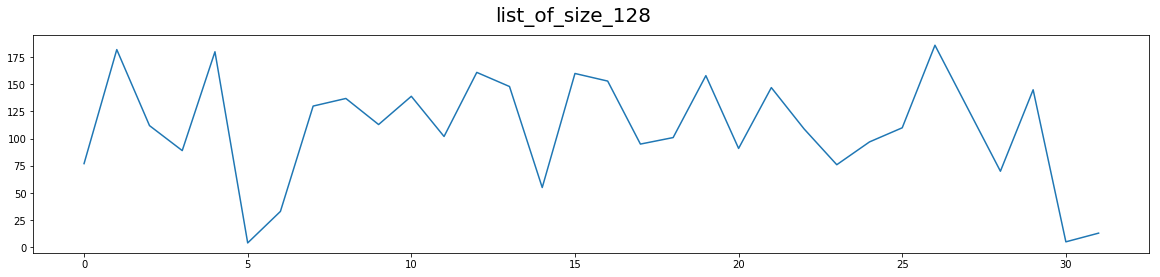

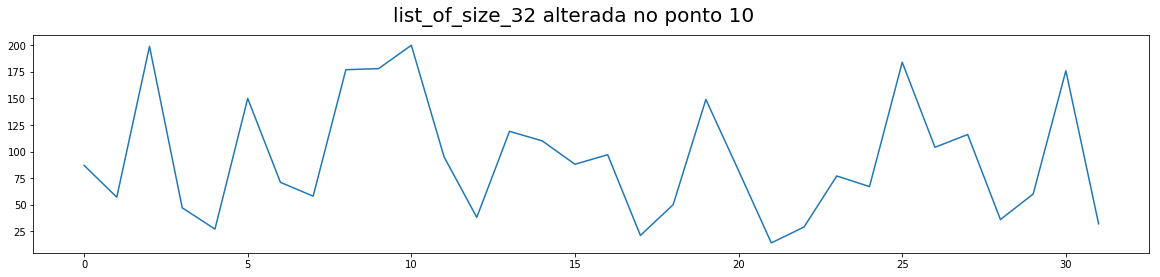

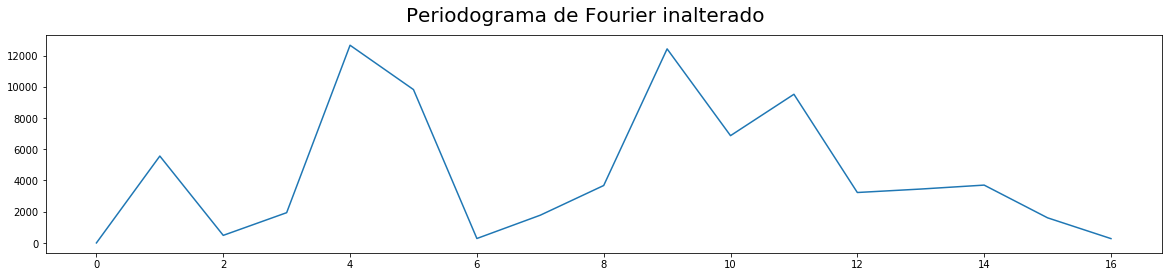

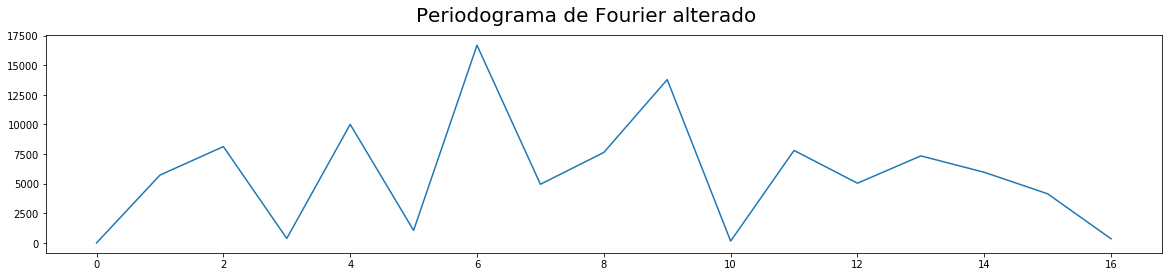

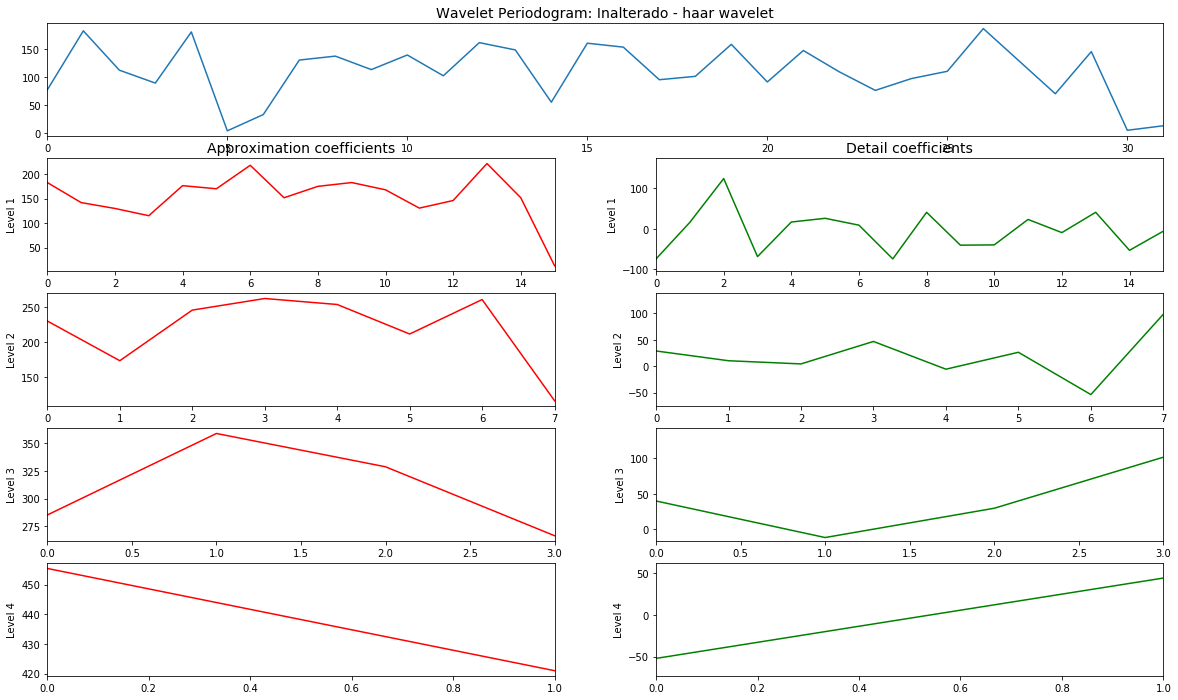

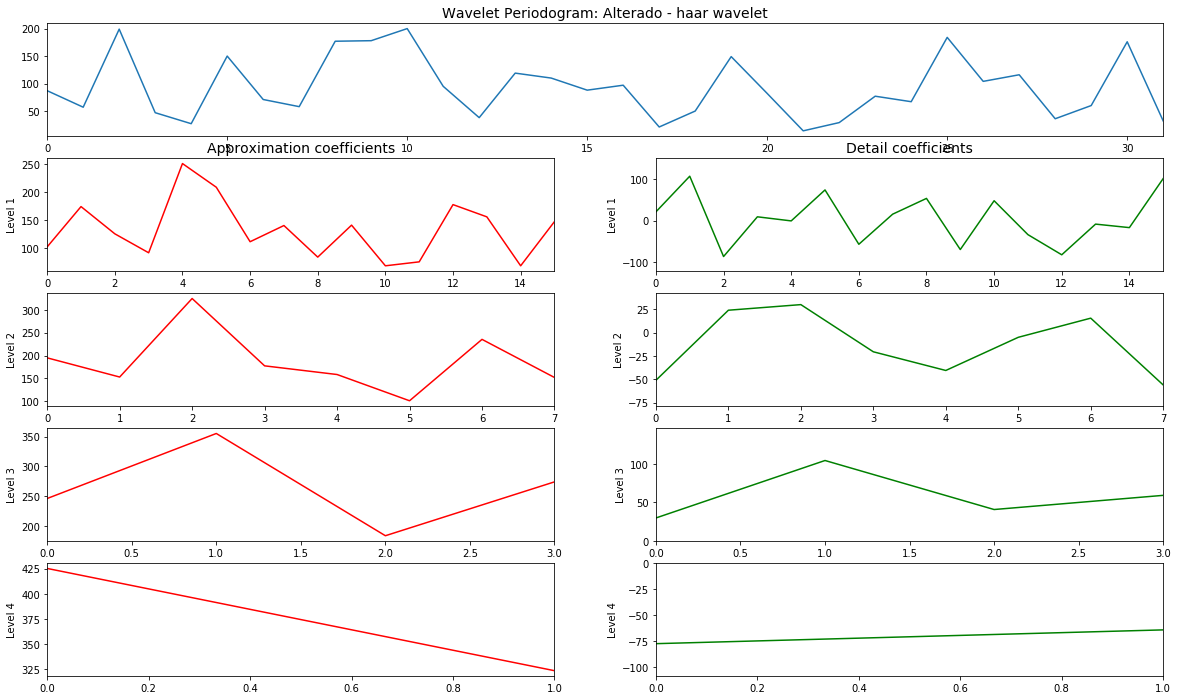

In [87]:
''' 
Exercício 6
Lista 5
Professora: Chang
Aluno: Renan de Luca Avila
'''
# Gerando uma lista de valores aleatórios e alterando somente um ponto na série:
list_of_size_32 = random.sample(range(1, 200), 32)
simple_plot(list_of_size_32, 'list_of_size_128')

# Alterando apenas 1 ponto na lista:
altered_list_of_size_32 = list_of_size_128
altered_list_of_size_32[10] = 200
simple_plot(altered_list_of_size_32, 'list_of_size_32 alterada no ponto 10')

# periodograma de Fourier
fs = 1 # sampling rate
freq, espectro = signal.periodogram(list_of_size_32, fs)
simple_plot(espectro, 'Periodograma de Fourier inalterado')

# periodograma de Fourier alterado
freq, espectro = signal.periodogram(altered_list_of_size_32, fs)
simple_plot(espectro, 'Periodograma de Fourier alterado')

# repetindo o processo para periodograma de ondaletas (NDWT/SWT)
wavelet_name = 'haar' # usando haar como no livro
mode = pywt.Modes.sp1DWT = 1
# Show DWT coefficients
use_dwt = True
ca,cd = plot_coeffs(list_of_size_32, wavelet_name,
            f"Wavelet Periodogram: Inalterado - {wavelet_name} wavelet",
            2,
            use_dwt)

use_dwt = True
ca,cd = plot_coeffs(altered_list_of_size_32, wavelet_name,
            f"Wavelet Periodogram: Alterado - {wavelet_name} wavelet",
            2,
            use_dwt)
